In [211]:
import scipy.io as sio
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline

In [212]:
data = sio.loadmat('digits.mat')
training_inputs = data['data']['training'][0][0][0]['inputs'][0]
training_targets = data['data']['training'][0][0][0]['targets'][0]
validation_inputs = data['data']['validation'][0][0][0]['inputs'][0]
validation_targets = data['data']['validation'][0][0][0]['targets'][0]
test_inputs = data['data']['test'][0][0][0]['inputs'][0]
test_targets = data['data']['test'][0][0][0]['targets'][0]

In [213]:
import numpy as np
def theta_to_model(theta):
    n_hid = int(len(theta) / (n_input+n_classes))
    input_to_hid = theta[:n_input*n_hid].reshape(n_input,n_hid).T
    hid_to_class = theta[n_input*n_hid:].reshape(n_hid, n_classes).T
    return input_to_hid, hid_to_class
    
def initial_model(n_hid, random = False):
    # n_hid: number of hidden logistic units
    n_params = (n_input+n_classes) * n_hid
    # No initialized ramdomly to get always the same result
    if random:
        as_row_vector = np.random.normal(0,0.01, n_params)
    else:
        as_row_vector = np.cos(range(0,(n_params)))*0.1
    return theta_to_model(as_row_vector)

In [218]:
# Create 2 hidden layers model
def multilayer_perceptron_2_layers(relu = True):
    # tf Graph input
    x = tf.placeholder("float", [None, n_input])
    y = tf.placeholder("int32", [None, n_classes])
    # Store layers weight & bias
    mean = 0.0
    stddev = 0.1
    weights = {
        'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1], mean=mean,stddev=stddev)),
        'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2], mean=mean,stddev=stddev)),
        'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes], mean=mean,stddev=stddev)),
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden_1], mean=mean,stddev=stddev)),
        'b2': tf.Variable(tf.random_normal([n_hidden_2], mean=mean,stddev=stddev)),
        'out': tf.Variable(tf.random_normal([n_classes], mean=mean,stddev=stddev)),
    }
    # Hidden layer with RELU activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    if relu:
        layer_1 = tf.nn.relu(layer_1)
    else:
        layer_1 = tf.nn.sigmoid(layer_1)
    # Hidden layer with RELU activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    if relu:
        layer_2 = tf.nn.relu(layer_2)
    else:
        layer_2 = tf.nn.sigmoid(layer_2)
    # Output layer with linear activation
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer,x, y, weights

In [215]:
# Create 1 hidden layer model
# tf Graph input

def multilayer_perceptron(random = False):
    mean = 0.0
    stddev = 0.1
    # Hidden layer with sigmoid activation
    biases = {
        'b1': tf.cast(tf.Variable(tf.random_normal([n_hidden_1], mean=mean,stddev=stddev)), dtype="float64"),
        'out': tf.cast(tf.Variable(tf.random_normal([n_classes], mean=mean,stddev=stddev)), dtype="float64"),
    }
    if random:
        x = tf.placeholder("float", [None, n_input])
        y = tf.placeholder("int32", [None, n_classes])
        weights = {
            'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
            'out': tf.Variable(tf.random_normal([n_hidden_1, n_classes]))
        }
    else:
        x = tf.placeholder("float64", [None, n_input])
        y = tf.placeholder("int32", [None, n_classes])
        w_hi_initial,w_out_initial = initial_model(n_hidden_1)
        weights = {
            'h1': tf.Variable(w_hi_initial.T),
            'out': tf.Variable(w_out_initial.T)
        }
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    #layer_1 = tf.matmul(x, weights['h1'])
    layer_1 = tf.nn.sigmoid(layer_1)
    # Output layer with linear activation
    #out_layer = tf.matmul(layer_1, weights['out'])
    out_layer = tf.matmul(layer_1, weights['out']) + biases['out']
    return out_layer, x, y, weights


In [216]:
def run_model(pred, x, y, weights, beta = 0):
    # Define loss and optimizer
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
    
    regularizer_out = tf.nn.l2_loss(weights['out'])
    regularizer_h1 = tf.nn.l2_loss(weights['h1'])
    
    regularizers = regularizer_out + regularizer_h1
    
    if 'h2' in weights:
        regularizers = regularizers + tf.nn.l2_loss(weights['h2'])
    
    cost = loss + beta*regularizers
    optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum = momentum).minimize(cost)
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)

    # Initializing the variables
    init = tf.global_variables_initializer()

    # Launch the graph
    n_training_cases = training_inputs.shape[1]
    training_data_losses = []
    validation_data_losses = []
    with tf.Session() as sess:
        sess.run(init)

        # Training cycle
        for optimization_iteration_i in range(iterations):
            training_batch_start = (optimization_iteration_i*mini_batch_size)%n_training_cases
            training_batch_inputs = training_inputs[:,training_batch_start:(training_batch_start+mini_batch_size)]
            training_batch_targets = training_targets[:,training_batch_start:(training_batch_start+mini_batch_size)]

            _, c = sess.run([optimizer, cost], feed_dict={x: training_batch_inputs.T,y: training_batch_targets.T})
            if optimization_iteration_i % display_step == 0:
                _, c = sess.run([optimizer, cost], feed_dict={x: training_inputs.T,y: training_targets.T})
                c_cv = sess.run(cost, feed_dict={x: validation_inputs.T,y: validation_targets.T})
                training_data_losses.append(c)
                validation_data_losses.append(c_cv)
        print("Optimization Finished!")

        # Test model
        correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
        # Calculate accuracy
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print("Accuracy:", accuracy.eval({x: training_inputs.T, y: training_targets.T}))
        print("Accuracy:", accuracy.eval({x: validation_inputs.T, y: validation_targets.T}))
        print("Accuracy:", accuracy.eval({x: test_inputs.T, y: test_targets.T}))
        print(optimization_iteration_i, training_data_losses[-1], validation_data_losses[-1])
    plt.figure(figsize = (20,10))
    plt.plot(training_data_losses, label = 'Training')
    plt.plot(validation_data_losses, label = 'Cross Validation')
    plt.legend(loc='best')
    plt.show()

# Equivalente a la de Hinton pero con tensorflow

Optimization Finished!
Accuracy: 1.0
Accuracy: 0.919
Accuracy: 0.920556
999 0.00321078741991 0.319957267094


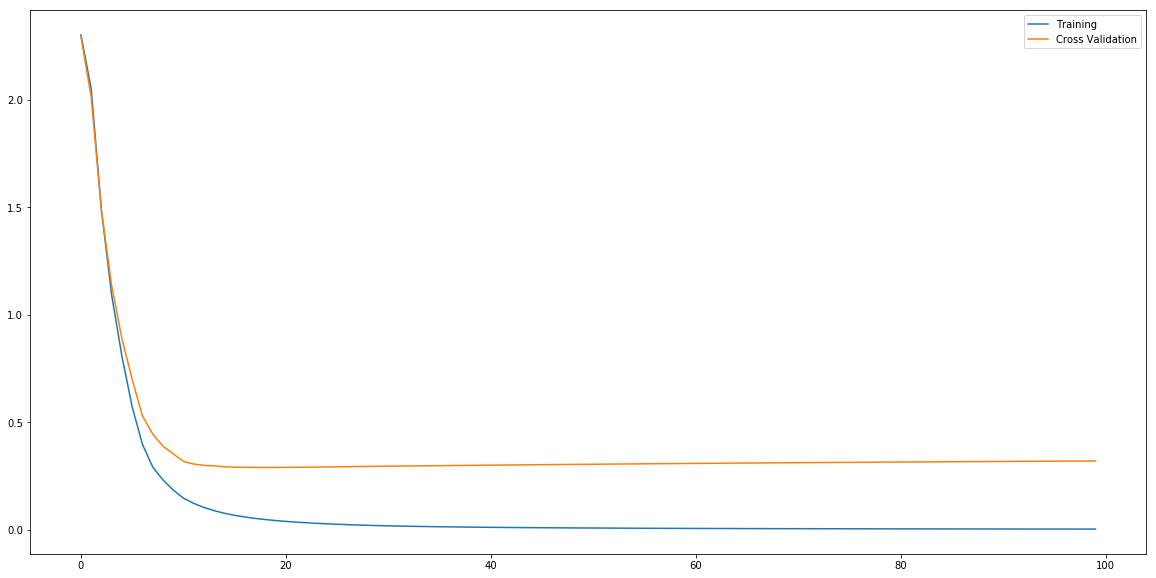

In [217]:
# Parameters
learning_rate = 0.35
iterations = 1000
mini_batch_size = 100
display_step = 10
momentum = 0.9

# Network Parameters
n_hidden_1 = 37 # 1st layer number of features
n_input = 256 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)
run_model(*multilayer_perceptron(random = False))

# La de Hinton con regularizacion

Optimization Finished!
Accuracy: 1.0
Accuracy: 0.923
Accuracy: 0.924889
999 0.248217297442 0.435532659804


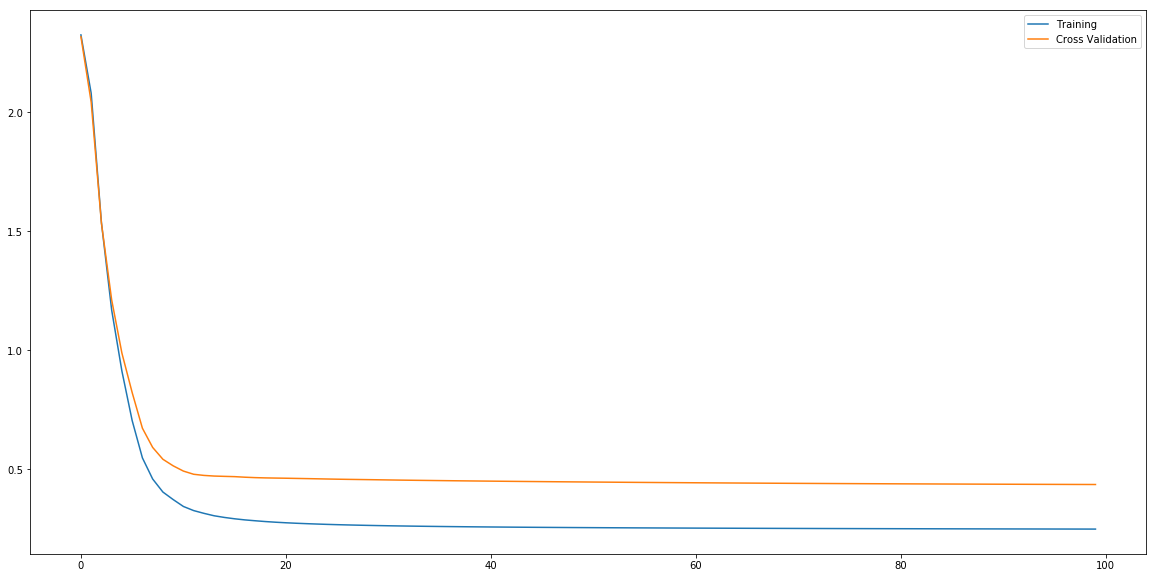

In [193]:
run_model(*multilayer_perceptron(random = False), beta = 0.001)

# Se agrega un "hidden layer" con relu's

Optimization Finished!
Accuracy: 1.0
Accuracy: 0.941
Accuracy: 0.934222
49999 0.0683524 0.288334


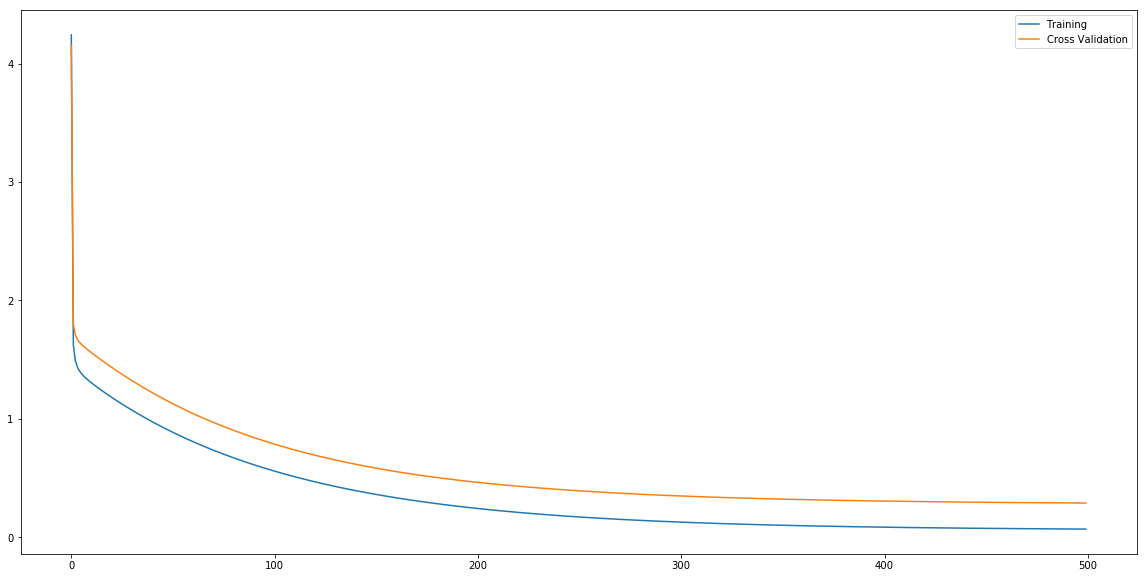

In [206]:
# Parameters
learning_rate = 0.005
iterations = 50000
mini_batch_size = 200
display_step = 100
momentum = 0.9

# Network Parameters
n_hidden_1 = 500 
n_hidden_2 = 300 
n_input = 256 
n_classes = 10 
run_model(*multilayer_perceptron_2_layers(), beta = 0.001)

# Igual a anterior pero con sigmoidea

Optimization Finished!
Accuracy: 0.999
Accuracy: 0.916
Accuracy: 0.912333
49999 0.300516 0.529006


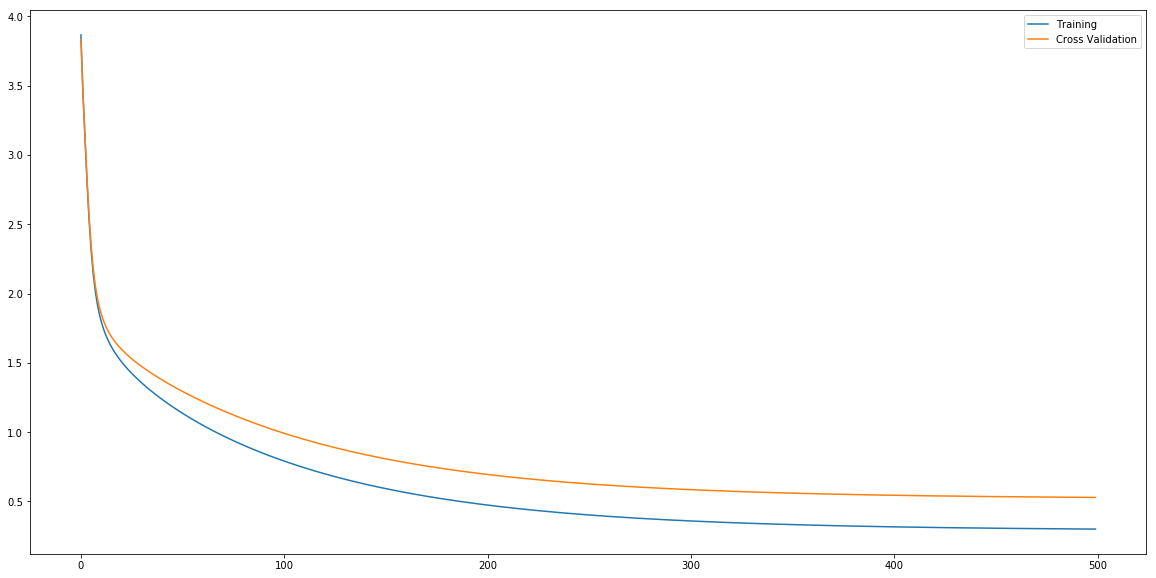

In [222]:
# Parameters
learning_rate = 0.005
iterations = 50000
mini_batch_size = 200
display_step = 100
momentum = 0.9

# Network Parameters
n_hidden_1 = 500 
n_hidden_2 = 300 
n_input = 256 
n_classes = 10 
run_model(*multilayer_perceptron_2_layers(relu = False), beta = 0.001)

# Parameters
learning_rate = 0.01
iterations = 50000
mini_batch_size = 200
display_step = 500
momentum = 0.9

# Network Parameters
n_hidden_1 = 256 
n_hidden_2 = 128 
n_input = 256 
n_classes = 10 
run_model(*multilayer_perceptron_2_layers(), beta = 0.001)

Optimization Finished!
Accuracy: 1.0
Accuracy: 0.933
Accuracy: 0.933444
49999 0.0567606 0.285725